# Facebook Post Recommender

In [2]:
import pickle
import shutil
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.testing import assert_almost_equal
import random

import torch
from torchvision import models
from torchvision import transforms

from PIL import Image
from tqdm import tqdm

In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
!pip install img2vec_pytorch

In [5]:
from img2vec_pytorch import Img2Vec

## Download Images

In [6]:
!pip install img2dataset

     |████████████████████████████████| 102 kB 12.8 MB/s 
     |████████████████████████████████| 133 kB 51.2 MB/s 
     |████████████████████████████████| 47 kB 4.9 MB/s 
     |████████████████████████████████| 87 kB 7.2 MB/s 
     |████████████████████████████████| 1.7 MB 47.4 MB/s 
     |████████████████████████████████| 60.5 MB 1.3 MB/s 
     |████████████████████████████████| 47.8 MB 1.1 MB/s 
     |████████████████████████████████| 144 kB 54.3 MB/s 
     |████████████████████████████████| 181 kB 53.5 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115942 sha256=c671f44b07169b6632d0f38595f24ac838b6add9cd985f37dd9cd59791883358
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=f11ba5da288353acdc042166c30228eeb66a556dee0d97ec66e24df37fa81ca1
  Stored in d

In [7]:
import pandas as pd
  
# Then loading csv file
df = pd.read_csv('/content/ad_photo_recommendation/data/images_to_rec.csv')

In [8]:
df

,Unnamed: 0,Image_Name,URL
0,0,mens-big-and-tall-classic-polo-b9k001arpc-001-...,https://cdn.shopify.com/s/files/1/2304/1219/pr...
1,0,mens-big-and-tall-classic-polo-b9k001arpc-001-...,https://cdn.shopify.com/s/files/1/2304/1219/pr...
2,0,mens-big-and-tall-classic-polo-b9k001arpc-001-...,https://cdn.shopify.com/s/files/1/2304/1219/pr...
3,0,mens-big-and-tall-classic-polo-b9k001arpc-001-...,https://cdn.shopify.com/s/files/1/2304/1219/pr...
4,0,mens-big-and-tall-classic-polo-b9k001arpc-001-...,https://cdn.shopify.com/s/files/1/2304/1219/pr...
...,...,...,...
7206,0,kids-carson-tee-bou329s1pc-001-black,https://cdn.shopify.com/s/files/1/2304/1219/pr...
7207,0,kids-carson-tee-bou329s1pc-001-black,https://cdn.shopify.com/s/files/1/2304/1219/pr...
7208,0,kids-carson-tee-bou329s1pc-001-black,https://cdn.shopify.com/s/files/1/2304/1219/pr...
7209,0,kids-carson-tee-bou329s1pc-001-black,https://cdn.shopify.com/s/files/1/2304/1219/pr...


In [9]:
df['URL'].to_csv('imglist_2.txt', sep="\n", index=False)

In [10]:
!img2dataset --url_list=/content/imglist_2.txt --output_folder=output_folder --thread_count=64 --image_size=256

Starting the downloading of this file
Sharding file number 1 of 1 called /content/imglist_2.txt
0it [00:00, ?it/s]File sharded in 1 shards
1it [06:36, 396.17s/it]
worker  - success: 1.000 - failed to download: 0.000 - failed to resize: 0.000 - images per sec: 18 - count: 7212
total   - success: 1.000 - failed to download: 0.000 - failed to resize: 0.000 - images per sec: 18 - count: 7212


In [11]:
# Save folder as a zip file
shutil.make_archive('output_folder', 'zip', 'output_folder') # Save folder as a zip file

'/content/output_folder.zip'

In [12]:
%ls

ad_photo_recommendation/  output_folder/     sample_data/
imglist_2.txt             output_folder.zip


In [13]:
# Get all image names in the folder
image_names = []
for filename in os.listdir('output_folder/00000'):
    if filename.endswith("jpg"): 
        # Your code comes here such as 
        print(filename)
        image_names.append(filename)

# Get the URL of each image
urls = []
for imagename in image_names:
  url = pd.read_json("output_folder/00000/"+imagename.replace("jpg", "json"), typ='series')[0]
  urls.append(url)

Streaming output truncated to the last 5000 lines.
000006601.jpg
000002589.jpg
000004902.jpg
000000385.jpg
000004039.jpg
000003680.jpg
000002163.jpg
000000351.jpg
000002390.jpg
000005469.jpg
000001419.jpg
000004251.jpg
000002003.jpg
000004114.jpg
000006713.jpg
000000606.jpg
000005099.jpg
000004844.jpg
000000362.jpg
000005914.jpg
000007121.jpg
000006295.jpg
000003177.jpg
000001223.jpg
000001991.jpg
000002114.jpg
000000339.jpg
000005541.jpg
000006574.jpg
000005038.jpg
000004118.jpg
000006327.jpg
000005615.jpg
000000045.jpg
000005943.jpg
000007022.jpg
000004604.jpg
000004022.jpg
000000171.jpg
000007090.jpg
000004567.jpg
000005052.jpg
000002661.jpg
000000745.jpg
000000637.jpg
000003791.jpg
000003198.jpg
000007129.jpg
000005799.jpg
000001335.jpg
000000372.jpg
000000173.jpg
000002327.jpg
000005381.jpg
000003905.jpg
000005105.jpg
000000551.jpg
000004412.jpg
000003165.jpg
000002981.jpg
000006773.jpg
000004642.jpg
000003998.jpg
000004298.jpg
000001528.jpg
000003342.jpg
000002747.jpg
000001755.j

In [14]:
pd.set_option('display.max_colwidth', None)
fb_images = pd.DataFrame({"Image_Name": image_names, "URL":urls})
fb_images.head(2)

,Image_Name,URL
0,000006703.jpg,https://cdn.shopify.com/s/files/1/2304/1219/products/B6U329S1PC-WHT_4.jpg?v=1647531976
1,000003194.jpg,https://cdn.shopify.com/s/files/1/2304/1219/products/B6S440R1FT-MULW_F1.jpg?v=1634760615


In [15]:
fb_images.to_csv("images_CO.csv")

## Embeddings

In [16]:
# Copy the image folder to clean it by removing json files and keep only jpg's
%cp -av output_folder/00000 images_only

Streaming output truncated to the last 5000 lines.
'output_folder/00000/000004703.jpg' -> 'images_only/000004703.jpg'
'output_folder/00000/000004703.json' -> 'images_only/000004703.json'
'output_folder/00000/000004715.jpg' -> 'images_only/000004715.jpg'
'output_folder/00000/000004715.json' -> 'images_only/000004715.json'
'output_folder/00000/000004706.jpg' -> 'images_only/000004706.jpg'
'output_folder/00000/000004706.json' -> 'images_only/000004706.json'
'output_folder/00000/000004716.jpg' -> 'images_only/000004716.jpg'
'output_folder/00000/000004716.json' -> 'images_only/000004716.json'
'output_folder/00000/000004717.jpg' -> 'images_only/000004717.jpg'
'output_folder/00000/000004717.json' -> 'images_only/000004717.json'
'output_folder/00000/000004718.jpg' -> 'images_only/000004718.jpg'
'output_folder/00000/000004718.json' -> 'images_only/000004718.json'
'output_folder/00000/000004714.jpg' -> 'images_only/000004714.jpg'
'output_folder/00000/000004714.json' -> 'images_only/000004714.jso

In [17]:
# Remove json files
dir_name = "images_only"
test = os.listdir(dir_name)

for item in test:
    if item.endswith(".json"):
        os.remove(os.path.join(dir_name, item))

In [18]:
inputDim = (224,224)
inputDir = "images_only"
inputDirCNN = "inputImagesCNN"

os.makedirs(inputDirCNN, exist_ok = True)

transformationForCNNInput = transforms.Compose([transforms.Resize(inputDim)])


for imageName in os.listdir(inputDir):
  try:
    I = Image.open(os.path.join(inputDir, imageName))
    newI = transformationForCNNInput(I)

    newI.save(os.path.join(inputDirCNN, imageName))
    
    newI.close()
    I.close()
  except Exception as e:
    pass
    print(e)
    logging.error(traceback.format_exc())


In [19]:
# Generate Embeddings

#img2vec = Img2Vec(cuda=True, model='vgg')
#img2vec = Img2Vec(cuda=True, model='densenet')
img2vec = Img2Vec(cuda=True, model='resnet-18')

allVectors = {}
print("Converting images to feature vectors:")
for image in tqdm(os.listdir("inputImagesCNN")):
  try:
    I = Image.open(os.path.join("inputImagesCNN", image))
    vec = img2vec.get_vec(I)
    allVectors[image] = vec
    I.close() 
  except:
    pass

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Converting images to feature vectors:


100%|██████████| 7211/7211 [00:49<00:00, 145.03it/s]


In [20]:
# Save embedding vectors
with open('PyschobunnyAllVectors.pkl', 'wb') as handle:
    pickle.dump(allVectors, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('PyschobunnyAllVectors.pkl', 'rb') as handle:
    allVectors = pickle.load(handle)

# close file
#f.close()

## Recommendation System

In [21]:
def getSimilarityMatrix(vectors):
    """
    Function to calculate the cosine similarity between vectors.
    
    Parameters
    ----------
    vectors : matrix
        Matrix with all of the embeddings.

    matrix : dataframe
        Dataframe with the cosine similarity between all vectors.
    """
    v = np.array(list(vectors.values())).T
    sim = np.inner(v.T, v.T) / ((np.linalg.norm(v, axis=0).reshape(-1,1)) * ((np.linalg.norm(v, axis=0).reshape(-1,1)).T))
    keys = list(vectors.keys())
    matrix = pd.DataFrame(sim, columns = keys, index = keys)
    
    return matrix
        
similarityMatrix = getSimilarityMatrix(allVectors)

In [22]:
# Top 10 Images
k = 10 

similarNames = pd.DataFrame(index = similarityMatrix.index, columns = range(k))
similarValues = pd.DataFrame(index = similarityMatrix.index, columns = range(k))

for j in tqdm(range(similarityMatrix.shape[0])):
    kSimilar = similarityMatrix.iloc[j, :].sort_values(ascending = False).head(k)
    similarNames.iloc[j, :] = list(kSimilar.index)
    similarValues.iloc[j, :] = kSimilar.values

# Save the model    
similarNames.to_pickle("similarNames.pkl")
similarValues.to_pickle("similarValues.pkl")

100%|██████████| 7211/7211 [00:10<00:00, 708.88it/s]


In [36]:
similarNames

,0,1,2,3,4,5,6,7,8,9
000006703.jpg,000006703.jpg,000006686.jpg,000005421.jpg,000004405.jpg,000006702.jpg,000002562.jpg,000004025.jpg,000004024.jpg,000006773.jpg,000005404.jpg
000003194.jpg,000003194.jpg,000003574.jpg,000004499.jpg,000001654.jpg,000001655.jpg,000004530.jpg,000001540.jpg,000002299.jpg,000001504.jpg,000005816.jpg
000004799.jpg,000004799.jpg,000004798.jpg,000002983.jpg,000002530.jpg,000002529.jpg,000003922.jpg,000003921.jpg,000006820.jpg,000004708.jpg,000004707.jpg
000002625.jpg,000002625.jpg,000002591.jpg,000004696.jpg,000004561.jpg,000004560.jpg,000004564.jpg,000000871.jpg,000000912.jpg,000004539.jpg,000003978.jpg
000000538.jpg,000000538.jpg,000000537.jpg,000003012.jpg,000003930.jpg,000000424.jpg,000003379.jpg,000000685.jpg,000003380.jpg,000000504.jpg,000005030.jpg
...,...,...,...,...,...,...,...,...,...,...
000003997.jpg,000003997.jpg,000003996.jpg,000004392.jpg,000004840.jpg,000003509.jpg,000004841.jpg,000000648.jpg,000000606.jpg,000003508.jpg,000004301.jpg
000005403.jpg,000005403.jpg,000005404.jpg,000005259.jpg,000005704.jpg,000003998.jpg,000003503.jpg,000001607.jpg,000000939.jpg,000006771.jpg,000005056.jpg
000005671.jpg,000005671.jpg,000005248.jpg,000005297.jpg,000004923.jpg,000006266.jpg,000004205.jpg,000005269.jpg,000003117.jpg,000006214.jpg,000001904.jpg
000000031.jpg,000000031.jpg,000000030.jpg,000004892.jpg,000004473.jpg,000006696.jpg,000000120.jpg,000006695.jpg,000003482.jpg,000004474.jpg,000005433.jpg


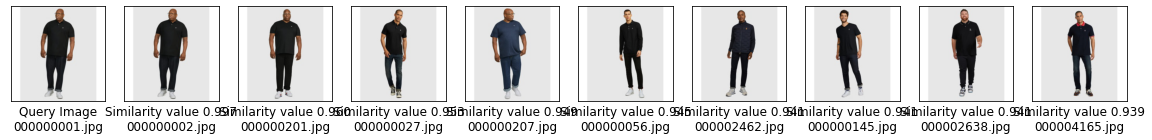

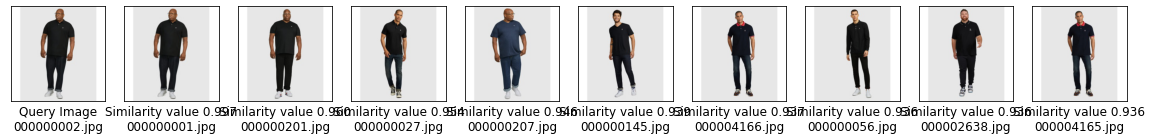

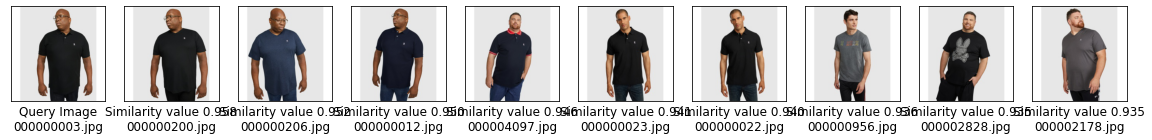

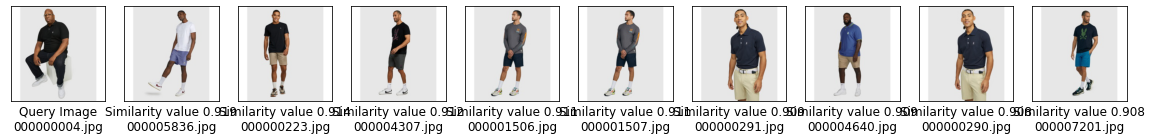

In [37]:
# Let's take the top images for some example images
inputImages = ['000000001.jpg', '000000002.jpg', '000000003.jpg', '000000004.jpg']

numCol = 10
numRow = 1

def setAxes(ax, image, query = False, **kwargs):
    value = kwargs.get("value", None)
    if query:
        ax.set_xlabel("Query Image\n{0}".format(image), fontsize = 12)
    else:
        ax.set_xlabel("Similarity value {1:1.3f}\n{0}".format( image,  value), fontsize = 12)
    ax.set_xticks([])
    ax.set_yticks([])
    
def getSimilarImages(image, simNames, simVals):
    if image in set(simNames.index):
        imgs = list(simNames.loc[image, :])
        vals = list(simVals.loc[image, :])
        if image in imgs:
            assert_almost_equal(max(vals), 1, decimal = 5)
            imgs.remove(image)
            vals.remove(max(vals))
        return imgs, vals
    else:
        print("'{}' Unknown image".format(image))
        
def plotSimilarImages(image, simiarNames, similarValues):
    simImages, simValues = getSimilarImages(image, similarNames, similarValues)
    fig = plt.figure(figsize=(20, 20))
    
    # now plot the  most simliar images
    for j in range(0, numCol*numRow):
        ax = []
        if j == 0:
            img = Image.open(os.path.join(inputDir, image))
            ax = fig.add_subplot(numRow, numCol, 1)
            setAxes(ax, image, query = True)
        else:
            img = Image.open(os.path.join(inputDir, simImages[j-1]))
            ax.append(fig.add_subplot(numRow, numCol, j+1))
            setAxes(ax[-1], simImages[j-1], value = simValues[j-1])
        img = img.convert('RGB')
        plt.imshow(img)
        img.close()
    
    plt.show()
        
for image in inputImages:
    plotSimilarImages(image, similarNames, similarValues)

In [49]:
URL_dict = fb_images.set_index('Image_Name').to_dict()
URL_dict

{'URL': {'000006703.jpg': 'https://cdn.shopify.com/s/files/1/2304/1219/products/B6U329S1PC-WHT_4.jpg?v=1647531976',
  '000003194.jpg': 'https://cdn.shopify.com/s/files/1/2304/1219/products/B6S440R1FT-MULW_F1.jpg?v=1634760615',
  '000004799.jpg': 'https://cdn.shopify.com/s/files/1/2304/1219/products/B6U719R1PC-WHT_1.jpg?v=1640817988',
  '000002625.jpg': 'https://cdn.shopify.com/s/files/1/2304/1219/products/B0W329Q1PO_NVY_3.jpg?v=1633038129',
  '000000538.jpg': 'https://cdn.shopify.com/s/files/1/2304/1219/products/B6T277P1PC-SST_1.jpg?v=1619029864',
  '000004312.jpg': 'https://cdn.shopify.com/s/files/1/2304/1219/products/B6T628R1PC-BLK_2_250x.jpg?v=1637695519',
  '000000132.jpg': 'https://cdn.shopify.com/s/files/1/2304/1219/products/B6A815A1HT-BLK_F2_1400x_e429b624-61b9-4a3d-aa11-d34f30d2f9c4.jpg?v=1638306611',
  '000000889.jpg': 'https://cdn.shopify.com/s/files/1/2304/1219/products/B6W311P1NS-SKG_1.jpg?v=1622217220',
  '000002355.jpg': 'https://cdn.shopify.com/s/files/1/2304/1219/produc

URL


In [24]:
def plot_images(images, figsize = (16,16), w=10, h=10, columns=6, rows=6):
  """
  Function to plot several images.
  
  Parameters
  ----------
  images : list
      List of image names.
  """
  fig = plt.figure(figsize=figsize)
  count = 1
  
  for image in images:
      img = Image.open(os.path.join(inputDir, image))
      fig.add_subplot(rows, columns, count)
      count +=1
      plt.imshow(img)
  plt.show()

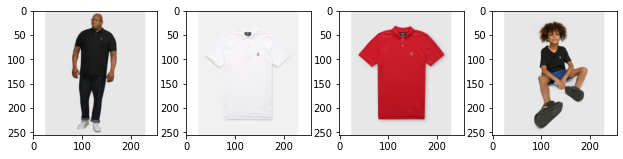

In [31]:
liked_images = ['000000001.jpg', '000000020.jpg', '000000050.jpg', '000000100.jpg']
plot_images(liked_images)

In [32]:
# Get recommendations
recos = []
for image in liked_images:
  simImages, simValues = getSimilarImages(image, similarNames, similarValues)
  all_images = [image]
  all_images.extend(simImages)
  recos.extend(all_images)

The first column has the "query" images so each row contains the recommendations for each query image.


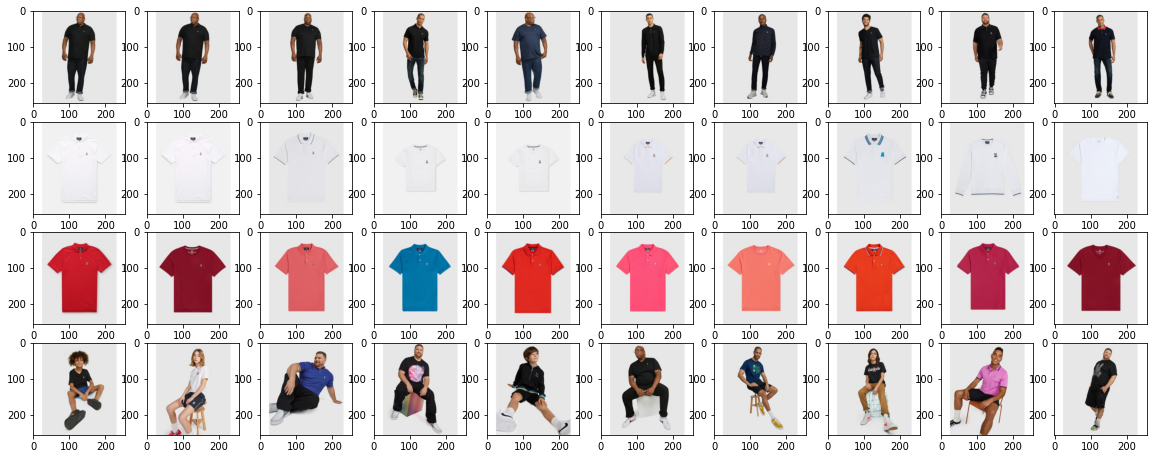

In [33]:
plot_images(recos, figsize = (20,20), w=20, h=20, columns=10, rows=10)

In [62]:
for item in list(similarNames.loc['000000001.jpg', :]):
  print(URL_dict['URL'][item])

https://cdn.shopify.com/s/files/1/2304/1219/products/B9K001ARPC-BLK_1_250x.jpg?v=1597344712
https://cdn.shopify.com/s/files/1/2304/1219/products/B9K001ARPC-BLK_1.jpg?v=1597344712
https://cdn.shopify.com/s/files/1/2304/1219/products/B9U100ARPC-BLK_1.jpg?v=1597344972
https://cdn.shopify.com/s/files/1/2304/1219/products/B6K001ARPC_BLK_3.jpg?v=1605730013
https://cdn.shopify.com/s/files/1/2304/1219/products/B9U100ARPC-HNV_1.jpg?v=1597345181
https://cdn.shopify.com/s/files/1/2304/1219/products/B6M658ARPC-BLK_1.jpg?v=1577123201
https://cdn.shopify.com/s/files/1/2304/1219/products/B6J326Q1NS-NVY_1.jpg?v=1632098331
https://cdn.shopify.com/s/files/1/2304/1219/products/B6U100ARPC-BLK_1.jpg?v=1603722336
https://cdn.shopify.com/s/files/1/2304/1219/products/B9K300Q1PC-BLK_2.jpg?v=1632159824
https://cdn.shopify.com/s/files/1/2304/1219/products/B6K613R1PC-NVY_1_250x.jpg?v=1637634951


In [63]:
for item in list(similarNames.loc['000000050.jpg', :]):
  print(URL_dict['URL'][item])

https://cdn.shopify.com/s/files/1/2304/1219/products/B6K001CRPC--BRI-4.jpg?v=1577123069
https://cdn.shopify.com/s/files/1/2304/1219/products/B6U014Q1PC-CRAN_F1.jpg?v=1628621196
https://cdn.shopify.com/s/files/1/2304/1219/products/B6K001S1PC-RSQ_F1.jpg?v=1642725305
https://cdn.shopify.com/s/files/1/2304/1219/products/B9K001Q1PC-ABU_F1.jpg?v=1626900338
https://cdn.shopify.com/s/files/1/2304/1219/products/B6K202S1PC-RES_F1.jpg?v=1645817707
https://cdn.shopify.com/s/files/1/2304/1219/products/B6K001R1PC-PKY_F1.jpg?v=1637797061
https://cdn.shopify.com/s/files/1/2304/1219/products/B6U104S1PC-RSQ_F1.jpg?v=1643228750
https://cdn.shopify.com/s/files/1/2304/1219/products/B9K204S1PC-RES_F1.jpg?v=1646237978
https://cdn.shopify.com/s/files/1/2304/1219/products/B6K001S1PC-MAGS_F1_250x.jpg?v=1645484418
https://cdn.shopify.com/s/files/1/2304/1219/products/B6U100Q1PC-CRAN_F1.jpg?v=1628623204
